# Assignment — Node Embeddings

In [1]:
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import requests
from time import time
import matplotlib.pyplot as plt

### CORA Exploratory Data Analysis

In this assignment, we will investigate node embedding algorithms on the Cora dataset. The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Let us take a closer look at this dataset.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/cora_cites.txt'
open('cora_cites.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/cora_content.txt'
open('cora_content.txt', 'wb').write(requests.get(url).content);

Number of nodes in the graph

In [3]:
cora = nx.read_edgelist('cora_cites.txt')
len(cora)

2708

Number of nodes in a gigantic connected component (GCC)

In [4]:
gcc_nodes = sorted(list(nx.connected_components(cora)), 
                   key=lambda x: len(x))[-1]
gcc_cora = cora.subgraph(gcc_nodes).copy()
len(gcc_cora)

2485

Nodes content

In [5]:
cora_content = pd.read_csv('cora_content.txt', sep='	', 
                           header=None, index_col=0)
cora_content.index = cora_content.index.astype('str')
cora_content.index.name = 'node'
cora_content.iloc[:5, :20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
node,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. In this assignment, we will only work with categories and will not touch any information about words.

Examples of node categories

In [6]:
category = cora_content.loc[gcc_nodes, [1434]]
category = category.rename(columns={1434: 'category_name'})
category.head()

,category_name
node,
1114442,Genetic_Algorithms
708945,Neural_Networks
248431,Genetic_Algorithms
218666,Case_Based
1107140,Theory


Category distribution

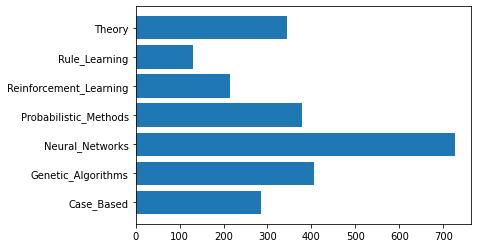

In [7]:
plt.barh(*np.unique(category, return_counts=True));

Rename categories to integer numbers (ids)

In [8]:
category['category_id'] = np.unique(category.category_name, 
                                    return_inverse = True)[1]
category.head()

,category_name,category_id
node,,
1114442,Genetic_Algorithms,1
708945,Neural_Networks,2
248431,Genetic_Algorithms,1
218666,Case_Based,0
1107140,Theory,6


Assortativity coefficient

In [9]:
nx.set_node_attributes(gcc_cora, category.category_id.to_dict(), 'category')
gcc_cora = nx.convert_node_labels_to_integers(gcc_cora)
round(nx.attribute_assortativity_coefficient(gcc_cora, 'category'), 2)

0.76

### Task 1. Node embedding visualization (1.5 points)

Let us compare embedding algorithms that we saw in previous assignments: 
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

There is a usefull python package [*Karate Club*](https://github.com/benedekrozemberczki/karateclub) that contains implementations of these algorithms. Also we will use sklearn implementation of truncated SVD.

In [10]:
!pip install karateclub==1.0.24 -q

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 1.8MB 21.7MB/s 
     |████████████████████████████████| 24.2MB 1.4MB/s 


In [11]:
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps
from sklearn.decomposition import TruncatedSVD, PCA

Embedding algorithms in Karate Club have a general interface

```python
model.fit(graph)
embedding = model.get_embedding()
```

However, the one inconvenient thing is that Walklets make a concatenation of Word2Vec embeddings to obtain final embeddings. In this way, the output dimensionality will be Word2Vec dimensionality multiplied by window size. A piece of source code:

```python
def get_embedding(self) -> np.array:
    r"""Getting the node embedding.

    Return types:
        * **embedding** *(Numpy array)* - The embedding of nodes.
    """
    return np.concatenate(self._embedding, axis=1)
```

Sometimes, it is usefull to have a deep representation of nodes, but for now we want to compare embeddings with the same dimensionality, so let us define our own class `PCAWalklets` that inherits `Walklets` and performs PCA reduction of embeddings into `self.dimensions` in the `get_embedding` method.

In [14]:
class PCAWalklets(Walklets):
    def get_embedding(self):
        return PCA(n_components=self.dimensions).fit_transform(super().get_embedding())

In [15]:
test_model = PCAWalklets()
test_model.fit(nx.karate_club_graph())
test_emb = test_model.get_embedding()
assert test_emb.shape == (34, 32)

Now let us visualize the 2d embeddings.

Write a function `xy_embeddings` that takes a graph, compute 16d embeddings, reduce them into 2d via PCA and returns in the order:
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

*Hints:* 
* *Suggested hyperparameters for DeepWalk and Walklets are `walk_number=10`, `walk_length=30`, `window_size=10`*
* *An importatnt thing is that `window_size` in DeepWalk reflects the maximum distance between the current and predicted node within a walk, while `window_size` in Walklets reflects the maximum power of an adjacency matrix, or equivalently, the maximum number of nodes needed to skip in a walk.*

In [16]:
def xy_embeddings(graph):
    all_embd = []
    dim = 16
    red_dim = 2
    for encoder in (LaplacianEigenmaps(dimensions=dim),
                    DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=dim), 
                    PCAWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=dim)):
        encoder.fit(graph)
        embedings = PCA(n_components=red_dim).fit_transform(encoder.get_embedding())
        all_embd.append(embedings)
    tsvd_emb = TruncatedSVD(n_components=red_dim).fit_transform(nx.to_numpy_array(graph))
    return all_embd[0], tsvd_emb, all_embd[1], all_embd[2]

In [17]:
laplacian_emb, svd_emb, deep_walk_emb, walklets_emb = xy_embeddings(gcc_cora)
assert (deep_walk_emb.shape == laplacian_emb.shape 
        == svd_emb.shape == walklets_emb.shape == (2485, 2))
assert -0.5 < laplacian_emb.min() < laplacian_emb.max() < 0.5
assert svd_emb[0].sum() > 15
assert round(abs(np.corrcoef(deep_walk_emb[:, 0], deep_walk_emb[:, 1])[0][1]), 
             2) == 0
assert round(abs(np.corrcoef(walklets_emb[:, 0], walklets_emb[:, 1])[0][1]), 
             2) == 0

Next, here we get a list of category ids to color data points

In [18]:
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
category_id[:10]

[1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

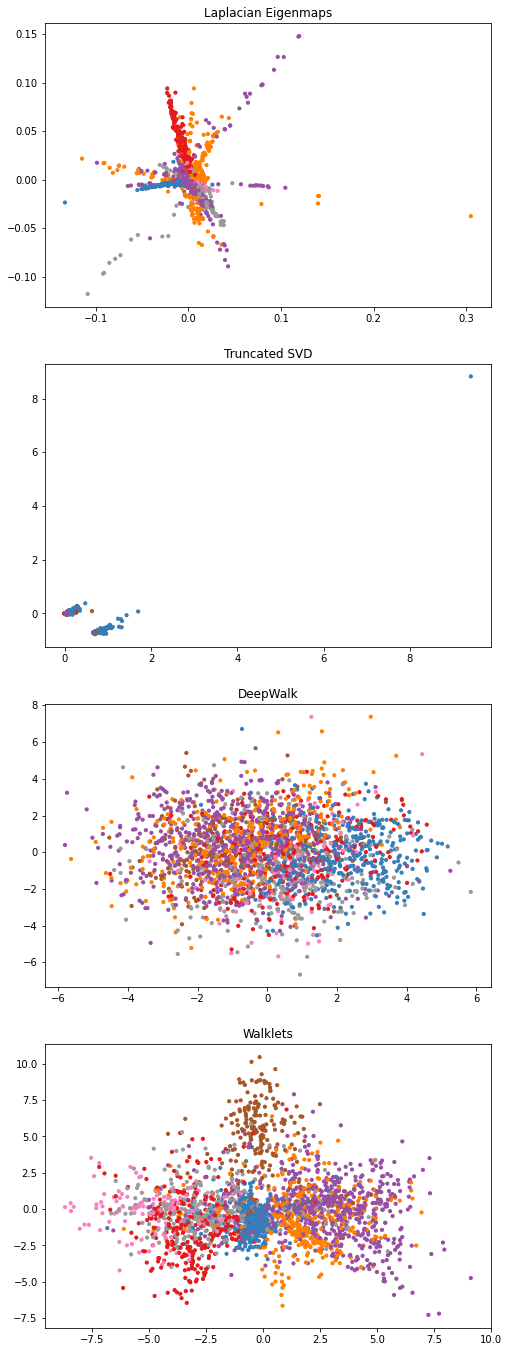

In [19]:
plt.figure(figsize=(8, 6*4))
cases = [[laplacian_emb, 'Laplacian Eigenmaps'], 
         [svd_emb, 'Truncated SVD'], 
         [deep_walk_emb, 'DeepWalk'], 
         [walklets_emb, 'Walklets']]
for i, (emb, title) in enumerate(cases):
    plt.subplot(4, 1, i+1)
    plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
    plt.title(title)

### Task 2. Test set size dependency (1.5 points)

Let us compare the quality of embedding algorithms on classification tasks depending on the size of test set.

Write a function `embeddings_score` that takes a graph and computes 16d embeddigns, splits the dataset (X is embedding, y is category id) into train and test sets, fit `GradientBoostingClassifier` and returns a list of lists:
* Micro-F1 score of Laplacian Eigenmaps for the test size 0.99, 0.95, 0.9, 0.8, 0.7
* The same for Truncated SVD
* The same for Deepwalk
* The same for Walklets

*Hints:* 
* *Use `train_test_split` splitting method from sklearn*
* *Use `f1_score(y_test, y_pred, average='micro')` method from sklearn to calculate Micro-F1 score*
* *It is ok if it takes about 2 minutes in Colab*

In [20]:
def embeddings_score(graph):
    category_id = nx.get_node_attributes(gcc_cora, 'category')
    category_id = list(category_id.values())
    dim = 16
    
    test_sizes = (0.99, 0.95, 0.9, 0.8, 0.7)
    
    def train(embeddings, category, test_size):
        train_emb, test_emb, cat_train, cat_test = train_test_split(embeddings, category, test_size=test_size)
        clsf = GradientBoostingClassifier()
        clsf.fit(train_emb, cat_train)
        predicted_cat = clsf.predict(test_emb)
        return f1_score(cat_test, predicted_cat, average="micro")
        
    all_f1_scores = []
    for encoder in (LaplacianEigenmaps(dimensions=dim),
                    DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=dim), 
                    PCAWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=dim)):
        encoder.fit(graph)
        embedings = encoder.get_embedding()
        
        f1_cls_score = []
        for test_size in test_sizes:
            f1_cls_score.append(train(embedings, category_id, test_size))
        all_f1_scores.append(f1_cls_score)
            
        
    tsvd_emb = TruncatedSVD(n_components=dim).fit_transform(nx.to_numpy_array(graph))
    
    f1_cls_score = []
    for test_size in test_sizes:
        f1_cls_score.append(train(tsvd_emb, category_id, test_size))
    all_f1_scores.append(f1_cls_score)
    
    return [all_f1_scores[i] for i in (0, 3, 1, 2)]

In [21]:
scores = embeddings_score(gcc_cora)
scores = np.array(scores)
assert scores.shape == (4, 5)
assert scores.mean() > 0.5
X = np.stack([np.ones(5), np.arange(5)], axis=1)
y = scores.mean(axis=0)
assert (np.linalg.inv(X.T @ X) @ X.T @ y)[0] > 0.4
mean_res = scores.mean(axis=1)
assert mean_res[0] > mean_res[3] > mean_res[1] > mean_res[2]

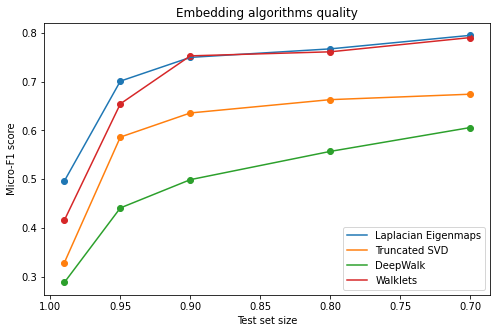

In [22]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores):
    plt.plot([0.99, 0.95, 0.9, 0.8, 0.7], score, label=labels[i])
    plt.scatter([0.99, 0.95, 0.9, 0.8, 0.7], score)
plt.legend()
plt.title('Embedding algorithms quality')
plt.xlabel('Test set size')
plt.ylabel('Micro-F1 score')
plt.gca().invert_xaxis()
plt.show()

### Task 3. Embedding dimensionality importance (3 points)

Another important property of the embedding is an ability to represent nodes in low-dimensional space. It will be great to quickly compress the most important and drop all excess imformation. Let us check how the dimensionality affects to quality and time cost.

Write a function `embeddings_dim` that takes a graph, computes embeddings, splits dataset into train and test sets with test size 0.95, computes Micro-F1 scores, time costs and returns a tuple:
* list of lists:
  * Micro-F1 score for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d
* list of lists:
  * Time cost (seconds) for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d

*Hints:*
* *Use `time()` to get a current time moment*
* *It is ok if it takes about 4 minutes in Colab*

In [32]:
def embeddings_dim(graph):
    
    category_id = nx.get_node_attributes(gcc_cora, 'category')
    category_id = list(category_id.values())
    dims = [8, 16, 32, 64, 128]
    
    test_size = 0.95
    
    def train(embeddings, category, test_size):
        train_emb, test_emb, cat_train, cat_test = train_test_split(embeddings, category, test_size=test_size)
        clsf = GradientBoostingClassifier()
        clsf.fit(train_emb, cat_train)
        predicted_cat = clsf.predict(test_emb)
        return f1_score(cat_test, predicted_cat, average="micro")
        
    all_f1_scores = []
    time_costs = []
    
    for dim in dims:
      f1_cls_score = []
      times = []
      for encoder in (LaplacianEigenmaps(dimensions=dim),
                      DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions=dim), 
                      PCAWalklets(walk_number=10, walk_length=30, window_size=10, dimensions=dim)):
          encoder.fit(graph)
          embedings = encoder.get_embedding()
          
          f1_cls_score.append(train(embedings, category_id, test_size))
          times.append(time())
              
          
      tsvd_emb = TruncatedSVD(n_components=dim).fit_transform(nx.to_numpy_array(graph))
      
      #f1_cls_score = []
      f1_cls_score.append(train(tsvd_emb, category_id, test_size))
      times.append(time())
      all_f1_scores.append(f1_cls_score)
      time_costs.append(times)

    k = 0
    for part in all_f1_scores:
      all_f1_scores[k] = [part[i] for i in (0, 3, 1, 2)]
      k = k + 1

    return all_f1_scores, time_costs

In [35]:
scores, time_cost = embeddings_dim(gcc_cora)
scores, time_cost = np.array(scores), np.array(time_cost)
assert scores.shape == time_cost.shape == (5, 4)
smean = scores.mean(axis=0)
assert smean.argmin() == 2
assert smean[1] < smean[0]
assert smean[1] < smean[3]
assert smean.mean() > 0.5
tcmean = time_cost.mean(axis=0)
assert tcmean.argmin() in [0, 1]
assert tcmean.argmax() == 3
assert time_cost[0, 0] < time_cost[-1, 0]

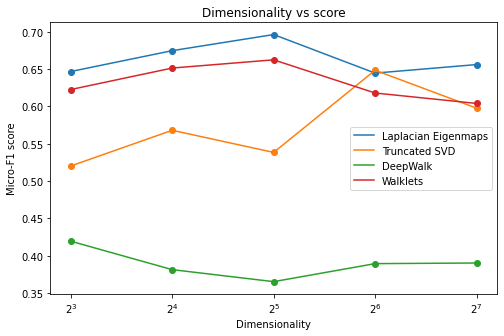

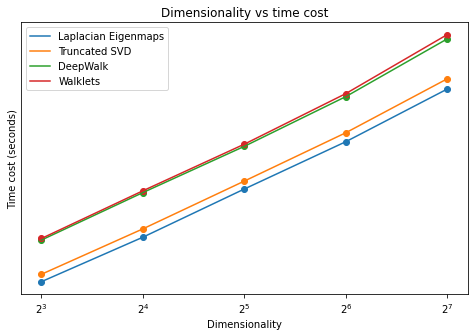

In [36]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores.T):
    plt.plot([8, 16, 32, 64, 128], score, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], score)
plt.legend()
plt.xscale('log', basex=2)
plt.xlabel('Dimensionality')
plt.ylabel('Micro-F1 score')
plt.title('Dimensionality vs score')
plt.show()

plt.figure(figsize=(8, 5))
for i, cost in enumerate(time_cost.T):
    plt.plot([8, 16, 32, 64, 128], cost, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], cost)
plt.legend()
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.xlabel('Dimensionality')
plt.ylabel('Time cost (seconds)')
plt.title('Dimensionality vs time cost')
plt.show()

### Task 4. Node2Vec (4 points)

In [37]:
!pip install gensim==3.6.0 -q

     |████████████████████████████████| 23.2MB 1.5MB/s 
ERROR: karateclub 1.0.24 has requirement gensim==3.8.3, but you'll have gensim 3.6.0 which is incompatible.


In [38]:
from gensim.models.word2vec import Word2Vec

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to the DeepWalk, but used *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/assignment_node_embedding/node_embedding.png' width=300>

For example, we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with a random walk.

In [47]:
import random

In [102]:

def alpha(length, p, q):
  if length == 0:
    return 1/p
  if length == 1:
    return 1
  if length == 2:
    return 1/q

def biased_random_walk(G, node, path_length, p, q):
    # YOUR CODE HERE

    random_walk = [node]
    k = 1
    while k < path_length:
      if k == 1:
        lst = [n for n in G.neighbors(node)]
        a = random.choice(lst)
        prev_node = node
        random_walk.append(a)
        k = k + 1
        current_node = int(random_walk[len(random_walk) - 1])
      if k > 1:
        lst = [n for n in G.neighbors(current_node)]
        probs = [alpha(nx.shortest_path_length(G, source=prev_node, target=i), p, q) for i in lst]
        probs = [float(i)/sum(probs) for i in probs]
        current_node = random.choices(lst, weights=probs, k=1)[0]
        prev_node = int(random_walk[len(random_walk) - 1])
        random_walk.append(current_node)
        k = k + 1

    return random_walk

    #raise NotImplementedError()

In [105]:
rw = biased_random_walk(gcc_cora, 0, 10, 0.1, 0.5)
assert len(rw) == 10
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=0.001, q=1000)
assert rw[0] == rw[2]
assert rw[1] == rw[3]
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=1000, q=0.001)
assert len(set(rw)) >= 3

Here are auxiliary methods that generates biased random walks and encode this walks using Word2Vec model.

In [106]:
def biased_random_walks(G, walk_number, walk_length, p, q):
    walks = []
    for node in tqdm(G.nodes):
        for _ in range(walk_number):
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

def node2vec_encode(G, walks, dimensions, window_size):
    walks_str = walks.astype('str').tolist()
    model = Word2Vec(walks_str, size=dimensions, hs=1, sg=1, 
                     alpha=0.05, iter=1, window=window_size)
    embedding = np.array([model.wv[str(n)] for n in range(len(G))])
    return embedding

In [107]:
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=0.25, q=0.5)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
assert emb.shape == (2485, 16)

Write a function `grid_search_pq`. Using 0.95 test set size, run the grid search for `GradientBoostingClassifier` and find the best values for $p, q \in \{0.25, 0.50, 1, 2, 4\}$ with respect to Micro-F1 score. Return the best $p, q$.

*Hints:*
* *Suggested hyperparameters are `walk_number=10`, `walk_length=30`, `window_size=10`, `dimensions=16`*
* *To pass time limits, calculate the best `p` and `q` and then rewrite the function as*

```python
def grid_search_pq(graph):
    return best_p, best_q
```

In [108]:
def grid_search_pq(graph):
    # YOUR CODE HERE
    best_p, best_q = 0.25, 0.25
    return best_p, best_q

In [109]:
best_p, best_q = grid_search_pq(gcc_cora)
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=best_p, q=best_q)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=0)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
assert f1_score(y_test, y_pred, average='micro') > 0.65

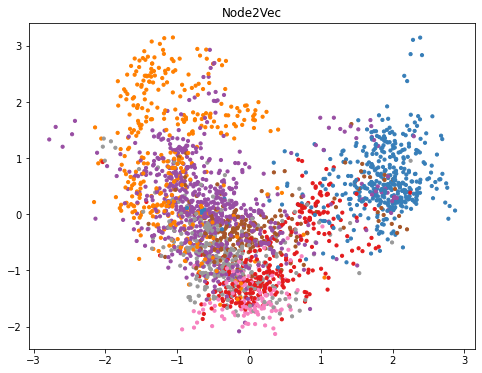

In [111]:
plt.figure(figsize=(8, 6))
model = PCA(n_components=2)
model.fit(emb)
emb = model.transform(emb)
plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
plt.title('Node2Vec')
plt.show()